# Dependence of US market on Chinese

## Introduction

**Hypothesis:**  
&emsp;The dynamics of trading in Chinese markets has an impact on the US market. In this paper I am making a reasoned conclusion about the presence or absence of influence, statistically proving it and making a model model, according to which traders, seeing how China traded off at night, will be able to guess how America will behave.

**Initial data:**
- S&P 500 - futures on the stock index S&P 500 (USA)
- FTSE China A50 - Shanghai Stock Exchange Index Futures (China)
- Coronavirus cases data (USA)

<font color='red'>**Time Zones on Data Set: EST (Eastern Standard Time)**</font>

In [1]:
from datetime import datetime

import numpy as np
from scipy import stats
import pandas as pd

from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from statsmodels.regression.rolling import RollingOLS
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.tsa.stattools import adfuller, coint, grangercausalitytests

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, f1_score
from sklearn.inspection import plot_partial_dependence, permutation_importance

In [2]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.gca().annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    ha='center', va='bottom')

## Data

S&P 500 index is measured in US dollars.

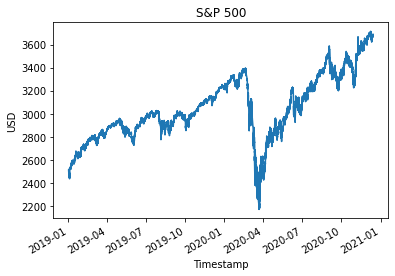

In [3]:
gspc = pd.read_csv('^GSPC.csv', index_col='Timestamp', parse_dates=True)[::-1]

gspc.Close.plot.line(title='S&P 500', ylabel='USD')
plt.show()

While FTSE China A50 is measured in Chinese yuan.

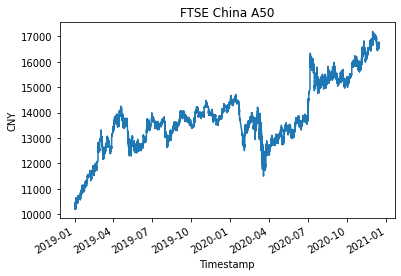

In [4]:
xin9 = pd.read_csv('XIN9.L.csv', index_col='Timestamp', parse_dates=True)[::-1]

xin9.Close.plot.line(title='FTSE China A50', ylabel='CNY')
plt.show()

Finally, we will require [coronavirus cases data](https://covidtracking.com/about-data/data-definitions/) in order to exclude it's influence from the analysis.

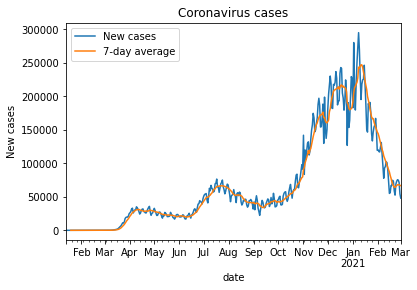

In [5]:
covid = pd.read_csv('covid.csv', index_col='date', parse_dates=True)[::-1]

covid.positiveIncrease.plot.line(title='Coronavirus cases', ylabel='New cases', label='New cases')
covid.positiveIncrease.rolling(7).mean().plot.line(label='7-day average')
plt.legend()
plt.show()

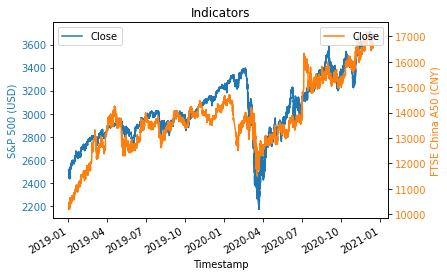

In [6]:
gspc.Close.plot.line()
plt.ylabel('S&P 500 (USD)', color='C0')
plt.tick_params(axis='y', labelcolor='C0')
plt.legend(loc=2)

plt.gca().twinx()

xin9.Close.plot.line(color='C1')
plt.ylabel('FTSE China A50 (CNY)', color='C1')
plt.tick_params(axis='y', labelcolor='C1')
plt.legend(loc=1)

plt.title('Indicators')
plt.show()

## Exchange rate

**Do we have to make any adjustments to normalize our time series?**  
In order to answer this question, we should take a look at USD/CNY exchange rate.

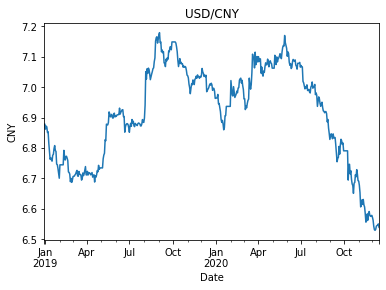

In [7]:
usdcny = pd.read_csv('USDCNY.csv', index_col='Date', parse_dates=True)[::-1] \
.rename(columns={'Price': 'Close'})

usdcny.Close.plot.line(title='USD/CNY', ylabel='CNY')
plt.show()

Unfortunately, I had no access to minute-by-minute exchange rate and wasn't able to acquire detailed information on which exact rates are used to calculate the indexes. But even with just daily rates, we can still make some heuristics.

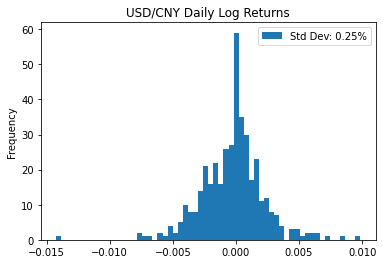

In [8]:
usdcny_daily_log_ret = np.log(usdcny.Close.resample('D').first()).diff()

usdcny_daily_log_ret.plot.hist(bins=60, title='USD/CNY Daily Log Returns',
                               label=f'Std Dev: {usdcny_daily_log_ret.std():.2%}')
plt.legend()
plt.show()

Daily volatility of USD/CNY exchange rate is only 0.25%.

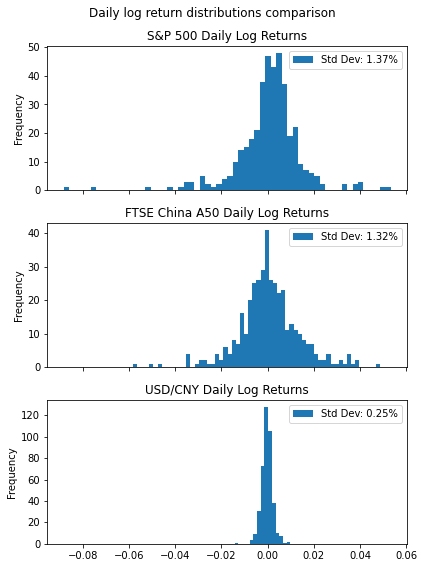

In [9]:
plt.figure(figsize=(6, 8))


plt.subplot(311)

gspc_daily_log_ret = np.log(gspc[gspc.index.hour == 0].Close.resample('D').first()).diff()

gspc_daily_log_ret.plot.hist(bins=60, title='S&P 500 Daily Log Returns',
                             label=f'Std Dev: {gspc_daily_log_ret.std():.2%}')
plt.legend()


plt.subplot(312, sharex=plt.gca())

xin9_daily_log_ret = np.log(xin9[xin9.index.hour == 13].Close.resample('D').first()).diff()

xin9_daily_log_ret.plot.hist(bins=60, title='FTSE China A50 Daily Log Returns',
                             label=f'Std Dev: {xin9_daily_log_ret.std():.2%}')
plt.legend()


plt.subplot(313, sharex=plt.gca())

usdcny_daily_log_ret.plot.hist(bins=15, title='USD/CNY Daily Log Returns',
                               label=f'Std Dev: {usdcny_daily_log_ret.std():.2%}')
plt.legend()


plt.suptitle('Daily log return distributions comparison')
plt.tight_layout()
plt.show()

However, volatilities of US and China markets are considerably higher, making 1.37 and 1.32 percent accordingly. Thus making the exchange rate factor negligible for the analysis.

## Statistical tests on hourly data

In [10]:
df_d0 = pd.DataFrame()
df_d0['gspc'] = gspc.Close.resample('H').last().rename('gspc')
df_d0['xin9'] = xin9.Close.resample('H').last().rename('xin9')

df_d1 = df_d0.copy().diff()

### Stationarity

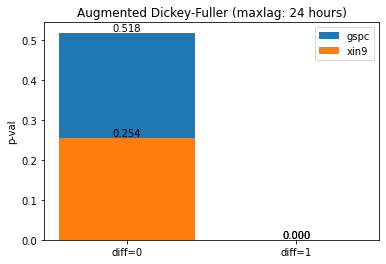

In [11]:
autolabel(
plt.bar(['diff=0', 'diff=1'],
        [adfuller(df_d0.gspc.dropna(), maxlag=24)[1],
         adfuller(df_d1.gspc.dropna(), maxlag=24)[1]], label='gspc'))
autolabel(
plt.bar(['diff=0', 'diff=1'],
        [adfuller(df_d0.xin9.dropna(), maxlag=24)[1],
         adfuller(df_d1.xin9.dropna(), maxlag=24)[1]], label='xin9'))
plt.ylabel('p-val')
plt.legend()
plt.title('Augmented Dickey-Fuller (maxlag: 24 hours)')
plt.show()

### Cointegration

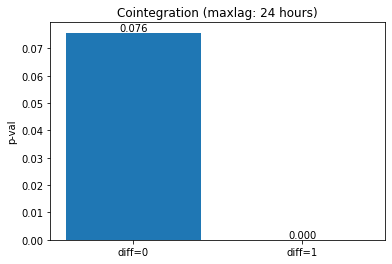

In [12]:
autolabel(
plt.bar(['diff=0', 'diff=1'],
        [coint(*np.hsplit(df_d0.dropna().values, 2), maxlag=24)[1],
         coint(*np.hsplit(df_d1.dropna().values, 2), maxlag=24)[1]]))
plt.ylabel('p-val')
plt.title('Cointegration (maxlag: 24 hours)')
plt.show()

### Granger causality

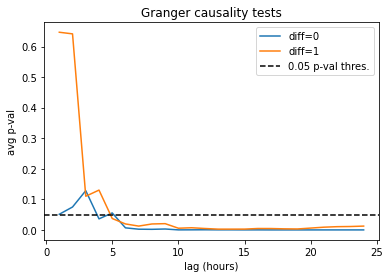

In [13]:
granger_d0 = grangercausalitytests(df_d0.dropna(), maxlag=24, verbose=False)
granger_d0 = {i: np.mean([k[1] for k in j[0].values()]) for i, j in granger_d0.items()}
granger_d0 = pd.Series(granger_d0)

granger_d1 = grangercausalitytests(df_d1.dropna(), maxlag=24, verbose=False)
granger_d1 = {i: np.mean([k[1] for k in j[0].values()]) for i, j in granger_d1.items()}
granger_d1 = pd.Series(granger_d1)

granger_d0.plot.line(title='Granger causality tests',
                     xlabel='lag (hours)', ylabel='avg p-val', label='diff=0')
granger_d1.plot.line(xlabel='lag (hours)', ylabel='avg p-val', label='diff=1')
plt.axhline(0.05, color='k', ls='--', label='0.05 p-val thres.')
plt.legend()
plt.show()

## Time scale

**Which time points should we compare?**  
If we build a plot of average trading volume per hour we will see, that the time ranges when stocks in China and America are traded do not intersect. Taking this into account, the most reasonable assumption would be to believe, that the closing late night price in the Chinese market would most strongly affect the opening price in the American, and then it's influence would weaken during the course of the day.

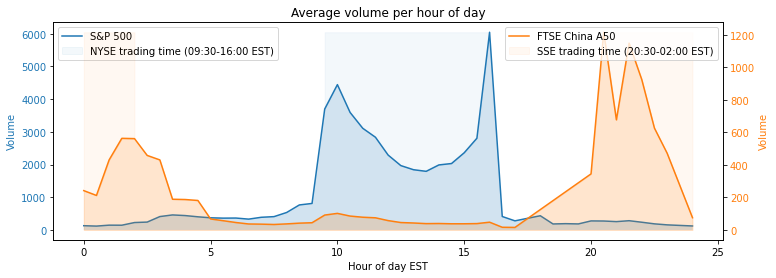

In [14]:
plt.figure(figsize=(12, 4))


gspc_volume_per_hour = gspc.Volume
# Rounding to half-hour
gspc_volume_per_hour.index = ((gspc.index.hour * 60 + gspc.index.minute) / 30).values.round() / 2
gspc_volume_per_hour = gspc_volume_per_hour.groupby(level=0).mean()

gspc_volume_per_hour.plot(label='S&P 500')
plt.fill_between(gspc_volume_per_hour.index, gspc_volume_per_hour, alpha=.2)

nyse_trading_time = np.arange(9.5, 16.5, .5)
plt.fill_between(nyse_trading_time, gspc_volume_per_hour[nyse_trading_time],
                 [gspc_volume_per_hour.max()]*nyse_trading_time.size, alpha=.05, color='C0',
                 label='NYSE trading time (09:30-16:00 EST)')

plt.ylabel('Volume', color='C0')
plt.tick_params(axis='y', labelcolor='C0')
plt.legend(loc=2)


plt.xlabel('Hour of day EST')
plt.gca().twinx()


xin9_volume_per_hour = xin9.Volume
# Rounding to half-hour
xin9_volume_per_hour.index = ((xin9.index.hour * 60 + xin9.index.minute) / 30).values.round() / 2
xin9_volume_per_hour = xin9_volume_per_hour.groupby(level=0).mean()

xin9_volume_per_hour.plot(label='FTSE China A50', color='C1')
plt.fill_between(xin9_volume_per_hour.index, xin9_volume_per_hour, alpha=.2, color='C1')

sse_trading_times = (np.arange(20.5, 24.5, .5), np.arange(0, 2.5, .5))
plt.fill_between(sse_trading_times[1], xin9_volume_per_hour[sse_trading_times[1]],
                 [xin9_volume_per_hour.max()]*sse_trading_times[1].size, alpha=.05, color='C1')
plt.fill_between(sse_trading_times[0], xin9_volume_per_hour[sse_trading_times[0]],
                 [xin9_volume_per_hour.max()]*sse_trading_times[0].size, alpha=.05, color='C1',
                 label='SSE trading time (20:30-02:00 EST)')

plt.ylabel('Volume', color='C1')
plt.tick_params(axis='y', labelcolor='C1')
plt.legend(loc=1)


plt.title('Average volume per hour of day')
plt.show()

Most trading activity picks up at 9:30 AM EST in US, which corresponds with the [opening times of US major stock exchanges such as New York Stock Exchange and Nasdaq](https://www.investopedia.com/ask/answers/040115/when-do-stock-market-exchanges-close.asp). The Chinese market is seen active till 5-6 AM EST. Therefore, it's safe to take 9-10 AM EST American index as daily opening and examine it's depence on Chinese index after 6 AM EST, taken as daily closing.

_Take note, that XIN9 is not traded during 5:30-8 PM EST_.

## Correlation

In [15]:
# %%time

# def objective(row):
#     gspc_open, gspc_close, xin9_open, xin9_close = \
#     row[['gspc_open', 'gspc_close', 'xin9_open', 'xin9_close']]

#     # Log change in American morning market index in comparison to yesterday's evening
#     gspc_diff = \
#     np.log(gspc[gspc.index.hour == gspc_open].Close.resample('D').mean()) - \
#     np.log(gspc[gspc.index.hour == gspc_close].Close.resample('D').mean()).shift()

#     # Log change in Chinese evening market index in comparison to the same day's late night/early morning
#     xin9_diff = \
#     np.log(xin9[xin9.index.hour == xin9_close].Close.resample('D').mean()) - \
#     np.log(xin9[xin9.index.hour == xin9_open].Close.resample('D').mean()).shift()

#     df = pd.concat([
#         gspc_diff.rename('us_diff'),
#         xin9_diff.rename('cn_diff')],
#         axis=1, join='inner').dropna()

#     if df.size:
#         pearson_test = stats.pearsonr(df.us_diff,
#                                       df.cn_diff)
#     else:
#         pearson_test = (np.nan, np.nan)

#     return pearson_test


# hours_opt_res = {'gspc_open': [], 'gspc_close': [],
#                  'xin9_open': [], 'xin9_close': [],
#                  'pearson_coef': [], 'p-value': []}

# gspc_trading_hours = gspc.index.hour.unique().sort_values()
# xin9_trading_hours = xin9.index.hour.unique().sort_values()

# for gspc_open in gspc_trading_hours: #[gspc_trading_hours <= 9]
#     for gspc_close in gspc_trading_hours[gspc_trading_hours > gspc_open]:

#         # Closing hour for China should be less than opening hour for America
#         # in order for us to come up with a trading strateg on time
#         for xin9_close in xin9_trading_hours[xin9_trading_hours < gspc_open]:
#             for xin9_open in xin9_trading_hours[xin9_trading_hours > xin9_close]:

#                 hours_opt_res['gspc_open'].append(gspc_open)
#                 hours_opt_res['gspc_close'].append(gspc_close)
#                 hours_opt_res['xin9_open'].append(xin9_open)
#                 hours_opt_res['xin9_close'].append(xin9_close)
#                 hours_opt_res['pearson_coef'].append(np.nan)
#                 hours_opt_res['p-value'].append(np.nan)


# hours_opt_res = pd.DataFrame(hours_opt_res)

# hours_opt_res[['pearson_coef', 'p-value']] = \
# pd.DataFrame(hours_opt_res.apply(objective, 1).tolist(), columns=['pearson_coef', 'p-value'])

# hours_opt_res.to_csv('hours_opt.csv', index=False)

# display(hours_opt_res.sort_values('pearson_coef', ascending=False).head(10))

The hypothesis is, that relative differnce of US market index prices during the exchanges' opening time today and their closing price the previous day, should correlate with the daily difference in Chinese prices during times of inactivity of Chinese exchanges.

$$US\ diff = intercept + \beta \cdot China\ diff + \varepsilon$$

- The change in US market is measuread in logarithmic difference between the average closing prices at 9:00-9:50 AM today and 6:00-6:50 PM the previous day.  
    $$US\ diff = log(avg(9AM\ close\ prices\ today)) - log(avg(4PM\ close\ prices\ yesterday))$$
- The change in Chinese market is measuread in logarithmic difference between the average closing prices at 8:00-8:50 AM today and 5:00-5:50 PM the previous day: we're taking the "closing" prices one hour before US opening in order to come up with a trading strategy on time.  
    $$China\ diff = log(avg(8AM\ close\ prices\ today)) - log(avg(5PM\ close\ prices\ yesterday))$$

We resort to logarithmic differences in order to [acquire a relative scale and address some of the mathematical downfalls of using other popular measures, such as percentage change](https://quantivity.wordpress.com/2011/02/21/why-log-returns/).

Current choice of hours to take was made by finding the right combination of opening/closing hours for US and China so that Pearson's correlation between the two resulting series is the highest.

Since:
1. The resulting function is not easily differentiable,
2. Has several logical constraints,
3. The absense of local extrema is not easily verifiable,  
and
4. The variables to optimise are discrete,

I resorted to simply brute-forcing the solution as opposite to using faster but less reliable optimisation methods adaptable for the task, such as [Bayesian optimisation](https://towardsdatascience.com/the-beauty-of-bayesian-optimization-explained-in-simple-terms-81f3ee13b10f).

,gspc_open,gspc_close,xin9_open,xin9_close,pearson_coef,p-value
12784,9,16,17,8,0.701,0.0
12937,9,17,17,8,0.696,0.0
13090,9,18,17,8,0.669,0.0
13243,9,19,17,8,0.620,0.0
13396,9,20,17,8,0.619,0.0


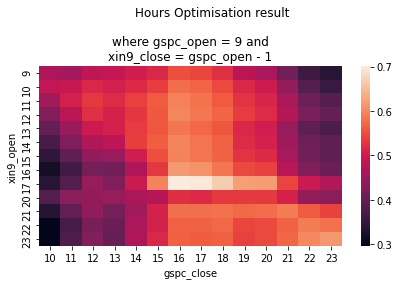

In [16]:
hours_opt = pd.read_csv('hours_opt.csv')

hours_opt_red = hours_opt[(hours_opt.gspc_open == 9) &
                          (hours_opt.xin9_close == hours_opt.gspc_open-1)]

display(hours_opt_red.sort_values('pearson_coef', ascending=False).head().round(3))

hours_opt_red_heat = hours_opt_red.pivot_table(index='xin9_open',
                                               columns='gspc_close',
                                               values='pearson_coef')

sns.heatmap(hours_opt_red_heat)
plt.title('where gspc_open = 9 and\nxin9_close = gspc_open - 1')
plt.suptitle('Hours Optimisation result')
plt.tight_layout()
plt.show()

**Why is xin9_close = gspc_open - 1?**  
The search made clear, that this combination leads to the best correlation between the indicators: by the opening time in US we should orient on the latest and most corrected Chinese prices.

**Why is gspc_open = 9?**  
This value was found, while trying to use the Chinese indicator to predict the US: the further away we go from the opening time of US exchanges, the less the predictive power of the Chinese indicator appears to become. Since China is mostly inactive during the day in America, it's influence gradually lowers, and American prices start evolving independently. Therefore, it's best to try predicting the first opening hour's dynamics.

In [17]:
# Log change in American morning market index in comparison to yesterday's evening
gspc_diff = \
np.log(gspc[gspc.index.hour == 9].Close.resample('D').mean()) - \
np.log(gspc[gspc.index.hour == 16].Close.resample('D').mean()).shift()

# Log change in Chinese evening market index in comparison to the same day's late night/early morning
xin9_diff = \
np.log(xin9[xin9.index.hour == 8].Close.resample('D').mean()) - \
np.log(xin9[xin9.index.hour == 17].Close.resample('D').mean()).shift()

df = pd.concat([
    gspc_diff.rename('us_diff'),
    xin9_diff.rename('cn_diff')],
    axis=1, join='inner').dropna()

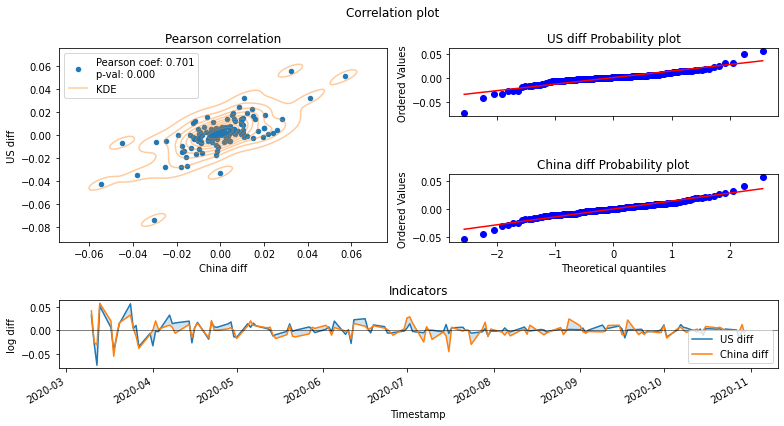

In [18]:
plt.figure(figsize=(11, 6))


plt.subplot2grid((3, 2), (0, 0), rowspan=2)
df.plot.scatter('cn_diff', 'us_diff', title='Pearson correlation', ax=plt.gca(),
                xlabel='China diff', ylabel='US diff',
                label='Pearson coef: {:.3f}\np-val: {:.3f}'.format(
                    *stats.pearsonr(df.us_diff, df.cn_diff)))
sns.kdeplot(x='cn_diff', y='us_diff', data=df, color='C1', alpha=.4, label='KDE')
plt.legend()


plt.subplot2grid((3, 2), (0, 1))
stats.probplot(df.us_diff, plot=plt)
plt.gca().set_title('US diff Probability plot')

plt.subplot2grid((3, 2), (1, 1), sharex=plt.gca())
stats.probplot(df.cn_diff, plot=plt)
plt.gca().set_title('China diff Probability plot')


plt.subplot2grid((3, 2), (2, 0), colspan=2)
df.us_diff.plot.line(label='US diff', title='Indicators', ylabel='log diff')
df.cn_diff.plot.line(label='China diff')
plt.fill_between(df.index, df.us_diff, df.cn_diff, alpha=.2)
plt.axhline(0, color='black', linewidth=.5)
plt.legend(loc=4)


plt.suptitle('Correlation plot')
plt.tight_layout()
plt.show()

As we can see, there is a strong linear correlation between the estimates: Pearson's coefficient is 0.7 and the probability of correlation's existence is high (p-value < 0.01).

## Rolling correlation and regression

The presented time series are clearly not dependent on just each other: both American and Chinese markets are subject to a whole array of various factors. Examining each of them would be a life time of work, and is beyond the scope of this paper. What one _can_ do, however, is to build a rolling regression model and try playing out the most important driving forces, if possible.

In [19]:
def r2_f1_mean(row):
    '''Returns mean of R2 and F1 scores per pandas row with true and pred columns.'''
    return (r2_score(row.true, row.pred) + f1_score(row.true > 0, row.pred > 0)) / 2

In [20]:
# %%time

# X = add_constant(df.cn_diff.copy())
# y = df.us_diff.copy()

# window_opt = {'window': [], 'order': [], 'true': [], 'pred': []}

# for window in range(7, 121):
#     for test_size in range(1, 32):
#         for poly_order in range(1, 14):

#             X_poly = X.copy()
#             for i in range(2, poly_order+1):
#                 X_poly[f'cn_diff^{i}'] = X.cn_diff ** i

#             X_train, X_test, y_train, y_test = train_test_split(
#                 X_poly, y, test_size=test_size, shuffle=False)

#             X_test = X_test.head(1)
#             y_test = y_test.head(1)

#             ols = OLS(y_train.tail(window), X_train.tail(window))
#             ols = ols.fit()

#             window_opt['window'].append(window)
#             window_opt['order'].append(poly_order)
#             window_opt['true'].append(y_test.iloc[0])
#             window_opt['pred'].append(ols.predict(X_test).iloc[0])

# window_opt = pd.DataFrame(window_opt)

# window_opt.to_csv('window_opt.csv', index=False)

# display(window_opt.groupby(['window', 'order']).apply(
#     r2_f1_mean).sort_values(ascending=False).head())

In [21]:
# window_opt = pd.read_csv('window_opt.csv') \
# .groupby(['window', 'order']).apply(r2_f1_mean).rename('R2_F1_mean')

# display(window_opt.sort_values(ascending=False).head().round(3))

# window_opt_heat = window_opt.reset_index().pivot_table(index='order',
#                                                        columns='window',
#                                                        values='R2_F1_mean')

# sns.heatmap(window_opt_heat.loc[:, window_opt_heat.columns >= 45])
# plt.title('Window Optimisation result')
# plt.show()

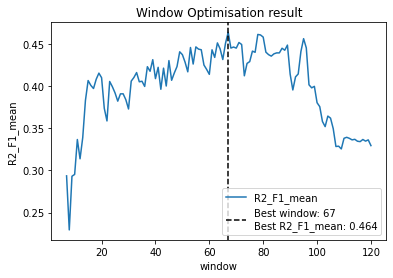

In [22]:
window_opt = pd.read_csv('window_opt.csv')
window_opt = window_opt[window_opt.order == 1].drop(columns='order') \
.groupby('window').apply(r2_f1_mean).rename('R2_F1_mean')

best_window = window_opt.idxmax()

window_opt.plot.line(title='Window Optimisation result',
                     ylabel='R2_F1_mean', label='R2_F1_mean')
plt.axvline(window_opt.idxmax(), color='k', ls='--',
            label=f'Best window: {best_window}\nBest R2_F1_mean: {window_opt.max():.3f}')
plt.legend()
plt.show()

The size of the window for rolling regression was optimised by searching through windows of size 7 to 120 days and measuring mean of R2 and F1 scores, acquired by predicting one following day's US difference, located among the latest 31 observations.
$$US\ diff = intercept + \beta * China\ diff + \varepsilon,$$
$$where\ \beta\ and\ intercept\ are\ approximated\ fitting\ an\ OLS\ on\ previous\ 67\ days\ of\ observations$$

In [23]:
model_res = pd.read_csv('window_opt.csv', index_col=['window', 'order'])
model_res = model_res[model_res.index == (best_window, 1)].reset_index(drop=True)

print(f'R2-score: {r2_score(*np.hsplit(model_res.values, 2)):.3f}')
print(f'F1-score: {f1_score(*np.hsplit(model_res.values > 0, 2)):.3f}')

R2-score: 0.166
F1-score: 0.762


The F1-score measures, how accurately the model predicts the direction in which the price will go - up or down, while also accounting for [probable class disbalance, thus making up for the limitations inherent in simpler accuracy metrics](https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2#:~:text=Accuracy%20is%20used%20when%20the,as%20in%20the%20above%20case.). Therefore, the F1-score of 0.762 means, that the model should make the correct guess about the direction of the price change in about 76.2% cases if probability of the market going up is 50 percent.

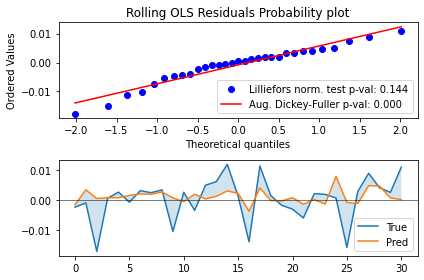

In [24]:
resid = model_res.true - model_res.pred

plt.subplot(211)
stats.probplot(resid, plot=plt)
plt.gca().set_title('Rolling OLS Residuals Probability plot')
plt.legend(['Lilliefors norm. test p-val: {:.3f}'.format(
    lilliefors(resid)[1]),
            'Aug. Dickey-Fuller p-val: {:.3f}'.format(
                adfuller(resid)[1])])

plt.subplot(212)
model_res.true.plot.line(label='True')
model_res.pred.plot.line(label='Pred')
plt.fill_between(model_res.index, model_res.true, model_res.pred, alpha=.2)
plt.axhline(0, color='black', linewidth=.5)
plt.legend()

plt.tight_layout()
plt.show()

Further improvements could include changing the rolling estimator to a polynomial regression, neural network or a random forest, tuning them, adding regularisation etc. (a polynomial fit of order 7 and 102 days window size, found during optimisation, resulted in 0.276 R2 and 0.75 F1 on the test set).

In [25]:
poly_res = pd.read_csv('window_opt.csv', index_col=['window', 'order'])
best_window_and_order = poly_res.groupby(level=(0, 1)) \
.apply(lambda row: (r2_score(row.true, row.pred) + f1_score(row.true > 0, row.pred > 0)) / 2).idxmax()
poly_res = poly_res[poly_res.index == best_window_and_order].reset_index(drop=True)

print('poly {1}, {0} days window'.format(*best_window_and_order))
print(f'R2-score: {r2_score(*np.hsplit(poly_res.values, 2)):.3f}')
print(f'F1-score: {f1_score(*np.hsplit(poly_res.values > 0, 2)):.3f}')

poly 7, 102 days window
R2-score: 0.276
F1-score: 0.750


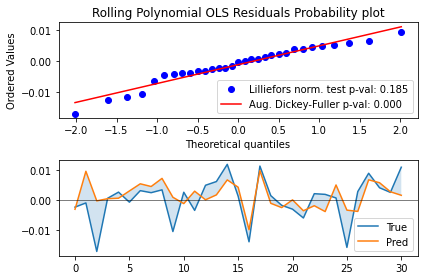

In [26]:
resid = poly_res.true - poly_res.pred

plt.subplot(211)
stats.probplot(resid, plot=plt)
plt.gca().set_title('Rolling Polynomial OLS Residuals Probability plot')
plt.legend(['Lilliefors norm. test p-val: {:.3f}'.format(
    lilliefors(resid)[1]),
            'Aug. Dickey-Fuller p-val: {:.3f}'.format(
                adfuller(resid)[1])])

plt.subplot(212)
poly_res.true.plot.line(label='True')
poly_res.pred.plot.line(label='Pred')
plt.fill_between(poly_res.index, poly_res.true, poly_res.pred, alpha=.2)
plt.axhline(0, color='black', linewidth=.5)
plt.legend()

plt.tight_layout()
plt.show()

However, let us keep with the simple rolling OLS on the monomial of degree 1, estimated above, to simplify the further analysis.

## Statistical tests on modified indicators

### Structural breaks

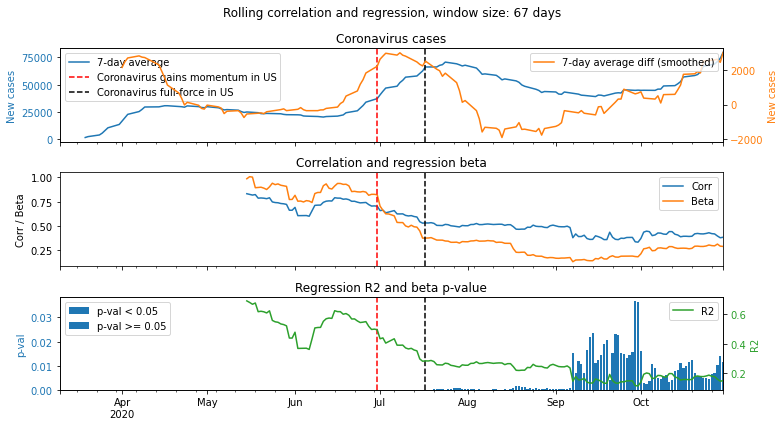

In [27]:
covid_window = 7
covid_cases = covid[covid.index.isin(df.index)].positiveIncrease.rename('Covid cases')

covid_moment = datetime(2020, 6, 30)
covid_full = datetime(2020, 7, 17)


window = best_window

roll_corr = df.us_diff.asfreq('D').rolling(f'{window}D').corr(df.cn_diff)
roll_corr.iloc[:(window-1)] = np.nan

rols = RollingOLS(df.us_diff.asfreq('D'),
                  add_constant(df.cn_diff).asfreq('D'),
                  window=window, missing='drop')
rols = rols.fit()
rols_pvals = pd.Series(rols.pvalues[:, -1], name='p-val', index=roll_corr.index)



plt.figure(figsize=(11, 6))

plt.subplot(311)
# covid_cases.plot.line(label='New cases')
covid_cases.rolling(covid_window).mean().plot.line(
    title='Coronavirus cases', label=f'{covid_window}-day average')
plt.ylabel('New cases', color='C0')
plt.tick_params(axis='y', labelcolor='C0')
plt.axvline(covid_moment, color='r', ls='--', label='Coronavirus gains momentum in US')
plt.axvline(covid_full, color='k', ls='--', label='Coronavirus full-force in US')
plt.legend(loc=2)

plt.gca().twinx()
covid_cases.rolling(covid_window).mean().diff().rolling(7).mean().plot.line(
    label=f'{covid_window}-day average diff (smoothed)', color='C1')
plt.ylabel('New cases', color='C1')
plt.tick_params(axis='y', labelcolor='C1')
plt.legend(loc=1)


plt.subplot(312, sharex=plt.gca())
roll_corr.plot.line(title=f'Correlation and regression beta', label='Corr')
rols.params.cn_diff.plot.line(label='Beta')
plt.ylabel('Corr / Beta')
plt.axvline(covid_moment, color='r', ls='--')
plt.axvline(covid_full, color='k', ls='--')
plt.legend()


plt.subplot(313, sharex=plt.gca())
plt.bar(roll_corr.index[rols_pvals < .05],
        rols_pvals[rols_pvals < .05], label='p-val < 0.05')
plt.bar(roll_corr.index[rols_pvals >= .05],
        rols_pvals[rols_pvals >= .05], label='p-val >= 0.05')
plt.axvline(covid_moment, color='r', ls='--')
plt.axvline(covid_full, color='k', ls='--')
plt.legend(loc=2)
plt.ylabel('p-val', color='C0')
plt.tick_params(axis='y', labelcolor='C0')
plt.title('Regression R2 and beta p-value')

plt.gca().twinx()
rols.rsquared.plot(label='R2', color='C2')
plt.legend(loc=1)
plt.ylabel('R2', color='C2')
plt.tick_params(axis='y', labelcolor='C2')

plt.suptitle(f'Rolling correlation and regression, window size: {window} days')
plt.tight_layout()
plt.show()

**Could we probably use a single OLS model instead?**  
[July 2020 appears to be the month, during which coronavirus hit the US particularly hard](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html). On the graphics above we can see a clear structural break in the dependence during exactly this time: correlation and predictive power of the Chinese indicator drops dramatically, albeit staying staying significant (p-values of the coefficients are consistently below 0.05). We can observe the same picture if we fit and compare two OLS models, one fitted on pre-July and the other on post-July data.

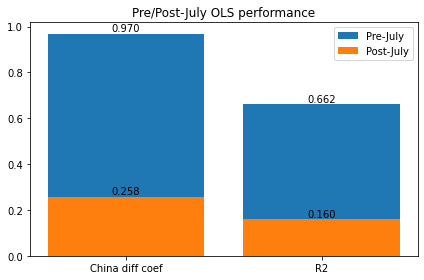

In [28]:
pre_jul_ols = OLS(df.loc[df.index < covid_moment, 'us_diff'],
                  add_constant(df.loc[df.index < covid_moment, 'cn_diff']))
pre_jul_ols = pre_jul_ols.fit()

post_jul_ols = OLS(df.loc[df.index >= covid_full, 'us_diff'],
                   add_constant(df.loc[df.index >= covid_full, 'cn_diff']))
post_jul_ols = post_jul_ols.fit()


autolabel(
plt.bar(['China diff coef', 'R2'],
        [pre_jul_ols.params.cn_diff, pre_jul_ols.rsquared], label='Pre-July'))
autolabel(
plt.bar(['China diff coef', 'R2'],
        [post_jul_ols.params.cn_diff, post_jul_ols.rsquared], label='Post-July'))
plt.legend()
plt.title('Pre/Post-July OLS performance')
plt.tight_layout()
plt.show()

[Chow test](https://www.statisticshowto.com/chow-test/) is used to verify the data set can not be represented with a single regression line (as opposed to several). It can be used to support our hypothesis, that the regression is different for pre- and post-July markets.
$$CHOW = \dfrac{(RSS_p - (RSS_1 + RSS_2)) / k}{(RSS_1 + RSS_2) / (N_1 + N_2 - 2 k)}$$

In [29]:
exc_jul_ols = OLS(df.loc[(df.index < covid_moment) | (df.index >= covid_full), 'us_diff'],
                  add_constant(df.loc[(df.index < covid_moment) | (df.index >= covid_full), 'cn_diff']))
exc_jul_ols = exc_jul_ols.fit()

def chow(olsp, ols1, ols2):
    '''Returns Chow F-value.'''
    k = 2 # number of parameters
    RSSP = (olsp.resid**2).sum() # residual sum of squares (pooled)
    RSS1 = (ols1.resid**2).sum() # residual sum of squares (pre-July)
    RSS2 = (ols2.resid**2).sum() # residual sum of squares (post-July)
    N1 = ols1.resid.size
    N2 = ols2.resid.size

    Fval = ((RSSP - (RSS1 + RSS2)) / k) / ((RSS1 + RSS2) / (N1 + N2 - 2*k))
    Pval = 1 - stats.f.cdf(Fval, N1 - k, N1 - k)

    return Fval, Pval

print('F-val: {:.4f}\nP-val: {:.4f}'.format(*chow(exc_jul_ols, pre_jul_ols, post_jul_ols)))

F-val: 10.9748
P-val: 0.0000


Our degrees of freedom are 60 and 58 accordingly. [Critical F-value for this combination is approximately 1.5343](https://www.statisticshowto.com/tables/f-table/), while the test resulted in 10.9748, which is significantly higher. This means the p-value is less than 0.05, and we can reject the null-hypothesis, that there is no structural break.

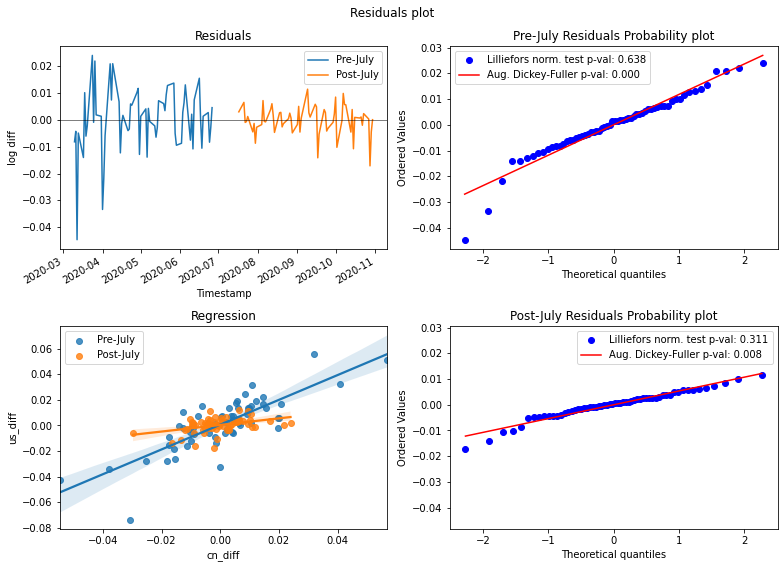

In [30]:
plt.figure(figsize=(11, 8))

plt.subplot2grid((2, 2), (0, 0), rowspan=1)
pre_jul_ols.resid.plot.line(label='Pre-July', title='Residuals')
post_jul_ols.resid.plot.line(label='Post-July')
plt.axhline(0, color='black', linewidth=.5)
plt.legend()
plt.ylabel('log diff')

plt.subplot2grid((2, 2), (1, 0), rowspan=1)
sns.regplot(x='cn_diff', y='us_diff', data=df.loc[df.index < covid_moment], label='Pre-July', seed=0)
sns.regplot(x='cn_diff', y='us_diff', data=df.loc[df.index >= covid_full], label='Post-July', seed=0)
plt.title('Regression')
plt.legend()

plt.subplot2grid((2, 2), (0, 1))
stats.probplot(pre_jul_ols.resid, plot=plt)
plt.gca().set_title('Pre-July Residuals Probability plot')
plt.legend(['Lilliefors norm. test p-val: {:.3f}'.format(
    lilliefors(pre_jul_ols.resid)[1]),
            'Aug. Dickey-Fuller p-val: {:.3f}'.format(
                adfuller(pre_jul_ols.resid)[1])])

plt.subplot2grid((2, 2), (1, 1), sharex=plt.gca(), sharey=plt.gca())
stats.probplot(post_jul_ols.resid, plot=plt)
plt.gca().set_title('Post-July Residuals Probability plot')
plt.legend(['Lilliefors norm. test p-val: {:.3f}'.format(
    lilliefors(post_jul_ols.resid)[1]),
            'Aug. Dickey-Fuller p-val: {:.3f}'.format(
                adfuller(post_jul_ols.resid)[1])])

plt.suptitle('Residuals plot')
plt.tight_layout()
plt.show()

[Augmented Dickey-Fuller unit root test](https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results) rejects the null-hypothesis of resudals of both models being non-stationary. While Lilliefors test can not reject them coming from a normal distribution. Both support our assumptions and conclusions so far.

In practice, nothing can guarantee us from such structural breaks. If we take a look at the graphics of rolling regression coefficients, we will observe the coefficient constantly evolving in complex patterns, which do not resemble a random process: the interaction of external factors is setting the trend for the strength of the dependence between Chinese and US markets. Therefore, it is more reasonable to use a rolling regression instead of a single one for making a prediction for the next day.

### Stationarity

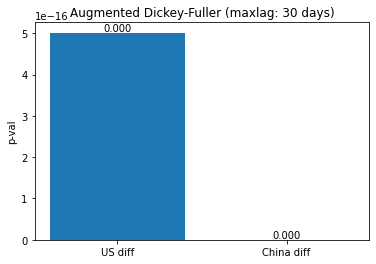

In [31]:
autolabel(
plt.bar(['US diff', 'China diff'],
        [adfuller(df.us_diff.dropna(), maxlag=30)[1],
         adfuller(df.cn_diff.dropna(), maxlag=30)[1]]))
plt.ylabel('p-val')
plt.title('Augmented Dickey-Fuller (maxlag: 30 days)')
plt.show()

### Cointegration

**Could it be, that there is no real dependence between the indicators, and they are driven by external factors alone?**  
This is not a simple question to answer. However, we can try making as many tests hinting otherwise in order to rule out some of the non-causality hypotheses. One such hypothesis, is that the indicators are not cointegrated. Cointegration means [there is an amplifying effect in between x and y - at any time point, we can always multiply x with the same parameter to get a value which is close to y](https://towardsdatascience.com/how-to-analyse-multiple-time-series-variable-5a8d3a242a2e).

In [32]:
df_caustest = df.copy()
df_caustest.cn_diff = df_caustest.cn_diff.shift(-1)
df_caustest = df_caustest.dropna()

In [33]:
print('Cointegration p-val: {:.4f}'.format(
    coint(df_caustest.us_diff, df_caustest.cn_diff, maxlag=1)[1]))

Cointegration p-val: 0.0000


P-value is less than 0.05. Therefore we reject the null-hypothesis that the series are not cointegrated.

### Granger causality

Another hypothesis we can check is that the Chinese indicator consistently precedes the US. This is called [Granger causality](https://www.statisticshowto.com/granger-causality/).

In [34]:
_ = grangercausalitytests(df_caustest, maxlag=1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=117.7788, p=0.0000  , df_denom=128, df_num=1
ssr based chi2 test:   chi2=120.5392, p=0.0000  , df=1
likelihood ratio test: chi2=85.4646 , p=0.0000  , df=1
parameter F test:         F=117.7788, p=0.0000  , df_denom=128, df_num=1


Statsmodels package has 4 various Granger causality tests in its [grangercausalitytests](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html) method. Each of them results in p-values less than 0.05. This means we can reject the null-hypothesis that the US indicator is not Granger-caused by the Chinese.

## Complex model example

A multilayered perceptron is a good example of an algorithm capable of approximating a smooth function of several variables, which appears to be the most probable case. Rather than reimplementing the rolling window with just one variable (China diff) as a predictor, we can reinforce our prediction by adding several lagged values of the target variable (US diff). The basic intuition behind this decision is that each time series contains information about itself, such as its trend and "elasticity". Therefore, the neural network is capable to deduce the several-days trend from the lagged values of the time series itself. This approach is comparable to classical models, such as SARIMAX (or, to be more specific, ARX - autoregressive model with exogenous regressors). However, instead of extracting individual components with statistical technics, the network will supposedly estimate the correct equation more precisely while also demanding less parameter turning and assumptions met.

In [35]:
# plot_acf(df.us_diff, title='US diff Autocorrelation')
# plt.show()

# plot_pacf(df.us_diff, title='US diff Partial Autocorrelation')
# plt.show()

In [36]:
# %%time

# df_c = df.copy()
# df_c['us_diff_l1'] = df_c.us_diff.shift()
# df_c['us_diff_l2'] = df_c.us_diff.shift(2)
# df_c['us_diff_l3'] = df_c.us_diff.shift(3)
# df_c['us_diff_l4'] = df_c.us_diff.shift(4)
# df_c = df_c.dropna()

# X = df_c.copy().drop(columns='us_diff')
# y = df_c.us_diff.copy()

# window_opt = {'window': [], 'true': [], 'pred': []}

# for window in range(7, 121):
#     for test_size in range(1, 32):

#         X_train, X_test, y_train, y_test = train_test_split(
#             X, y, test_size=test_size, shuffle=False)

#         X_test = X_test.head(1)
#         y_test = y_test.head(1)

#         mlp = MLPRegressor(hidden_layer_sizes=(100), max_iter=1000,
#             random_state=0, early_stopping=True, validation_fraction=0.2)
#         mlp.fit(X_train.tail(window), y_train.tail(window))
#         pred = mlp.predict(X_test)[0]

#         window_opt['window'].append(window)
#         window_opt['true'].append(y_test.iloc[0])
#         window_opt['pred'].append(pred)

# window_opt = pd.DataFrame(window_opt)

# window_opt.to_csv('comp_window_opt.csv', index=False)

# display(window_opt.groupby('window').apply(
#     r2_f1_mean).sort_values(ascending=False).head())

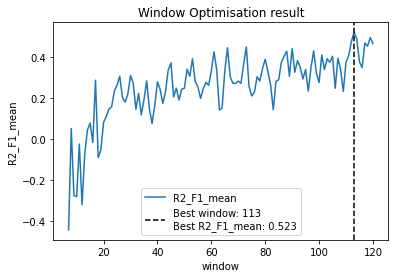

In [37]:
window_opt = pd.read_csv('comp_window_opt.csv')
window_opt = window_opt \
.groupby('window').apply(r2_f1_mean).rename('R2_F1_mean')

best_window = window_opt.idxmax()

window_opt.plot.line(title='Window Optimisation result',
                     ylabel='R2_F1_mean', label='R2_F1_mean')
plt.axvline(window_opt.idxmax(), color='k', ls='--',
            label=f'Best window: {best_window}\nBest R2_F1_mean: {window_opt.max():.3f}')
plt.legend()
plt.show()

### Model specifications and feature interpretation

- The MLP model uses a window of 113 previous days (rows) to train.
- In addition to China diff it also uses 4 lagged values of US diff as predictors (columns).
- The network architecture is 1 hidden layer of 100 perceptrons with ReLU activations and Adam solver.
- The loss function is squared-loss.
- 0.2 validation fraction is split from the window before training to compute loss used for early stopping.

In [38]:
df_c = df.copy()
df_c['us_diff_l1'] = df_c.us_diff.shift()
df_c['us_diff_l2'] = df_c.us_diff.shift(2)
df_c['us_diff_l3'] = df_c.us_diff.shift(3)
df_c['us_diff_l4'] = df_c.us_diff.shift(4)
df_c = df_c.dropna()

X = df_c.copy().drop(columns='us_diff')
y = df_c.us_diff.copy()

X_latest, y_latest = X.tail(best_window), y.tail(best_window)

mlp = MLPRegressor(
    hidden_layer_sizes=(100), max_iter=1000,
    random_state=0, early_stopping=True, validation_fraction=0.2).fit(
    X_latest, y_latest)

#### Partial dependence plot

Partial dependence plots are used to examine how black-box model's features impact the prediction when changed. It is a simple method, which fixes all columns except one and then computes mean predictions, replacing the values in the examined column with an array of exactly same constant values and gradually increasing them.

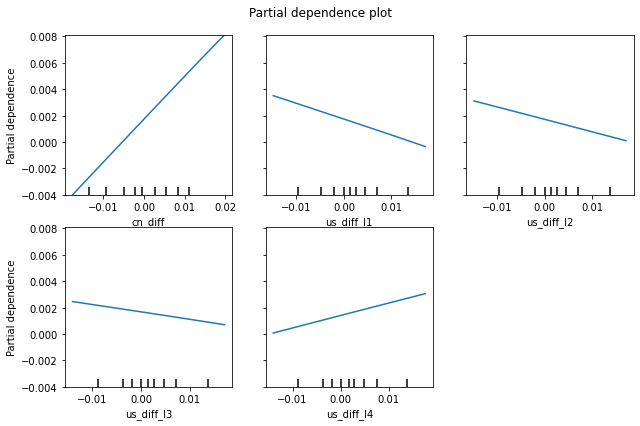

In [39]:
plt.figure(figsize=(9, 6))
plot_partial_dependence(mlp, X_latest, X_latest.columns, random_state=0, ax=plt.gca())
plt.suptitle('Partial dependence plot')
plt.tight_layout()
plt.show()

The relationships, approximated by the MLP, appear to be linear.

#### Feature importances

Permutation feature importance is a method to calculate relative feature importances. Here we apply permutations to an examined column to see, how much worse the performance of an estimator becomes according to our metric of choice.

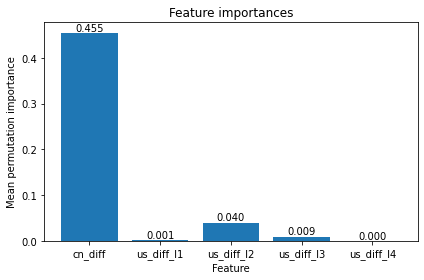

In [40]:
importances = pd.DataFrame()
importances['feature'] = X_latest.columns
importances['importances_mean'] = \
permutation_importance(mlp, X_latest, y_latest, n_repeats=5, random_state=0)['importances_mean']

autolabel(
plt.bar(X_latest.columns,
        permutation_importance(mlp, X_latest, y_latest, n_repeats=5, random_state=0)['importances_mean']))
plt.xlabel('Feature')
plt.ylabel('Mean permutation importance')
plt.title('Feature importances')
plt.tight_layout()
plt.show()

The most significant feature with the strongest impact on prediction is still China diff, while the other factors only play a supporting role.

**Why not add lagged values of China diff as predictors?**  
Experimenting with such approach proved to give worse results, than leaving only the current latest. This can probably be explained by the fact, that Chinese and US markets, even if correlated to some extent, evolve in individual fashion, and the latest several-days trend in US does not necessarily repeat the Chinese.

**Why not add more hidden layers?**  
On the partial dependence plot above, we can see that the approximated function is linear. Experimenting with more layers produced almost linear curves as well, while lowering the scores. The training is early-stopped the moment when the model approximates a near-linear function, hinting at a possibility, that the linear model could probably appear to be the best describing the data.

**What other models have been tested?**  
[Random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and [ARMA with fully automatic parameter selection](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) were also tested using the same rolling window framework described above. However, their performance did not match the MLP. Remembering our previous conclusions, a rolling ARX or ARMAX model with fixed number of lagged values and carefully chosen optimiser could have probably gotten on par.

### Model comparison

In [41]:
mlp_res = pd.read_csv('comp_window_opt.csv', index_col='window')
mlp_res = mlp_res[mlp_res.index == best_window].reset_index(drop=True)

comparison = pd.DataFrame()

comparison['Model'] = ['Simple Rolling OLS', 'Rolling Polynomial OLS', 'Rolling MLP with lagged predictors']
comparison['R2'] = [
    r2_score(*np.hsplit(model_res.values, 2)),
    r2_score(*np.hsplit(poly_res.values, 2)),
    r2_score(*np.hsplit(mlp_res.values, 2))]
comparison['F1'] = [
    f1_score(*np.hsplit(model_res.values > 0, 2)),
    f1_score(*np.hsplit(poly_res.values > 0, 2)),
    f1_score(*np.hsplit(mlp_res.values > 0, 2))]

display(comparison.round(3))

,Model,R2,F1
0,Simple Rolling OLS,0.166,0.762
1,Rolling Polynomial OLS,0.276,0.750
2,Rolling MLP with lagged predictors,0.202,0.844


As we can see, the MLP outperforms the simple rolling OLS in terms of both R2 and F1. It doesn't beat the polynomial OLS in terms of R2, however, it's F1-score is significantly higher, making it arguably a more practically applicable trading model: it doesn't matter so much, if we don't win as much profit as we predict, since we make correct assumptions on the price movement directions, thus minimizing the risk of losing.

## Prediction

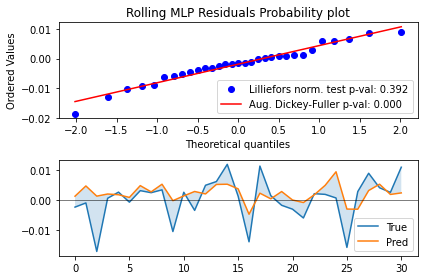

In [42]:
resid = mlp_res.true - mlp_res.pred

plt.subplot(211)
stats.probplot(resid, plot=plt)
plt.gca().set_title('Rolling MLP Residuals Probability plot')
plt.legend(['Lilliefors norm. test p-val: {:.3f}'.format(
    lilliefors(resid)[1]),
            'Aug. Dickey-Fuller p-val: {:.3f}'.format(
                adfuller(resid)[1])])

plt.subplot(212)
mlp_res.true.plot.line(label='True')
mlp_res.pred.plot.line(label='Pred')
plt.fill_between(mlp_res.index, mlp_res.true, mlp_res.pred, alpha=.2)
plt.axhline(0, color='black', linewidth=.5)
plt.legend()

plt.tight_layout()
plt.show()

## Conclusion

1. We can not reject that Chinese market's nightly performance influences US.
2. If there really is such influence, its strength changes over time.
3. Opening dynamics of S&P 500 can be predicted by FTSE China A50 nightly performance using an OLS model fitted on previous 67 days results. If given fresh data in time, the model is ready to make prediction about the dynamics of the next hour at 9AM EST.
4. However, predictive power is not guaranteed to be strong: R2 is around 0.17 when predicting 31 latest observations, and the model is able to guess the direction of price movement correctly in around 76% cases. We can expect to observe comparable results if there is no change in external factors.
5. If simplicity and interpretability are not in priority, and our goal is performance, the rolling inner model can be replaced by a more complex one (polynomial fit, ARMA, random forest, neural network), with added predictors (_probably_: volume, rolling volatility, lagged values/moving averages - ARIMA style etc.) and the window - readjusted. One such experiment brought R2 score up to 0.28 while keeping F1 at approximately same level of 0.75, which is probably still not applicable to use in full automatic mode, but a considerable improvement nevertheless.
6. The best model I was able to compose is an MLP on a rolling window of size 113, using 4 lagged values of US diff in addition to China diff as predictors. The model arguably outperformed both simple and polynomial rolling OLS, coming second in terms of R2 score (0.2) and first in F1 (0.84) by a wide margin.

In [43]:
display(comparison.round(2))

,Model,R2,F1
0,Simple Rolling OLS,0.17,0.76
1,Rolling Polynomial OLS,0.28,0.75
2,Rolling MLP with lagged predictors,0.20,0.84


7. Taking everything above into account, blindly using the model is not advised: it can be used as a supporting tool or may make profit on statistically significant numbers, but in order to make it a fully automated decision-making tool, more factors should be added and complex trading strategies should be applied, especially if it is a big one-time sell/purchase.